# Continuous Evaluation

In [1]:
# change these to try this notebook out
BUCKET = 'munn-sandbox'
PROJECT = 'munn-sandbox'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '2.1'

In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.1


In [4]:
%%bash
gsutil ls gs://$BUCKET/txtcls/data/

gs://munn-sandbox/txtcls/data/titles_full.csv
gs://munn-sandbox/txtcls/data/titles_sample.csv


In [5]:
!gsutil cp gs://$BUCKET/txtcls/data/titles_full.csv .

Copying gs://munn-sandbox/txtcls/data/titles_full.csv...
/ [1 files][  5.4 MiB/  5.4 MiB]                                                
Operation completed over 1 objects/5.4 MiB.                                      


In [6]:
import pandas as pd
from tensorflow.keras.utils import to_categorical

DATASET_NAME = "titles_full.csv"
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(DATASET_NAME, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,led inventor and employer settle for $8.1m 2005,nytimes
1,yc-backed photo-sharing service picplum loses ...,techcrunch
2,as facebook turns 10 zuckerberg wants to chan...,nytimes
3,6 big healthtech ideas that will change medici...,techcrunch
4,building the prince of persia sources to creat...,github


In [7]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [8]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [9]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [10]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

In [11]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [12]:
X_train[:3]

array(['led inventor and employer settle for $8.1m  2005 ',
       'yc-backed photo-sharing service picplum loses one co-founder',
       'as facebook turns 10  zuckerberg wants to change how tech industry works'],
      dtype=object)

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model

%matplotlib inline

In [16]:
print(tf.__version__)

2.1.1


In [15]:
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

In [19]:
MODEL_DIR = "./text_model"

In [23]:
#def confidence(x):
#    return tf.reduce_max(x, axis=1)

def txt_source(x):
    labels = ['github', 'techcrunch', 'nytimes']
    return tf.cast(tf.argmax(x, axis=1), tf.float32)

    #return tf.expand_dims(tf.constant(1.), axis=0)


def build_model(hub_module, name):
    #model = Sequential([
    #    hub_module, # TODO 2
    #    Dense(16, activation='relu'),
    #    Dense(N_CLASSES, activation='softmax')
    #], name=name)
    inputs = Input(shape=[], dtype=tf.string, name="text")
    module = hub_module(inputs)
    h1 = Dense(16, activation='relu', name="h1")(module)
    outputs = Dense(N_CLASSES, activation='softmax', name='outputs')(h1)
    score = Lambda(lambda x: tf.reduce_max(x, axis=1), name="score")(outputs)
    pred_label = Lambda(lambda x: txt_source(x), name="pred_label")(outputs)
    
    model = Model(inputs=inputs, outputs=[outputs])
    extra_model = Model(inputs=inputs, outputs=[outputs, pred_label, score])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    extra_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model, extra_model

In [21]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping(), TensorBoard(model_dir)],
    )
    return history

In [24]:
swivel_model = build_model(swivel_module, name='swivel')

In [26]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [27]:
swivel_history = train_and_evaluate(data, val_data, swivel_model[0])

Train on 91392 samples, validate on 4811 samples
Epoch 1/100
91392/91392 [==============================] - 4s 41us/sample - loss: 1.2985 - accuracy: 0.2760 - val_loss: 1.2328 - val_accuracy: 0.2835
Epoch 2/100
91392/91392 [==============================] - 1s 6us/sample - loss: 1.1638 - accuracy: 0.3239 - val_loss: 1.1294 - val_accuracy: 0.3590
Epoch 3/100
91392/91392 [==============================] - 1s 6us/sample - loss: 1.0832 - accuracy: 0.4056 - val_loss: 1.0613 - val_accuracy: 0.4386
Epoch 4/100
91392/91392 [==============================] - 1s 6us/sample - loss: 1.0245 - accuracy: 0.4744 - val_loss: 1.0056 - val_accuracy: 0.4914
Epoch 5/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.9717 - accuracy: 0.5249 - val_loss: 0.9527 - val_accuracy: 0.5392
Epoch 6/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.9198 - accuracy: 0.5656 - val_loss: 0.9013 - val_accuracy: 0.5789
Epoch 7/100
91392/91392 [==============================]

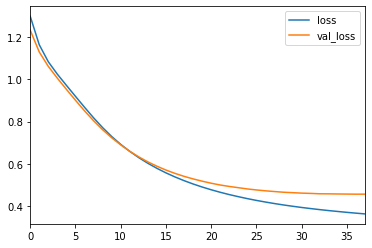

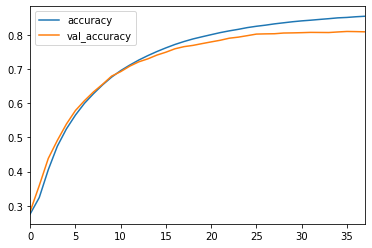

In [28]:
history = swivel_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [31]:
swivel_model[1].predict(x=["led inventor and employer settle for $8.1m 2005", 
                           ])

[array([[0.00264016, 0.6643035 , 0.3330564 ]], dtype=float32),
 array([1.], dtype=float32),
 array([0.6643035], dtype=float32)]

In [32]:
tf.saved_model.save(swivel_model[1], './swivel_model/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./swivel_model/assets


INFO:tensorflow:Assets written to: ./swivel_model/assets


In [47]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir ./swivel_model/
!find ./swivel_model/

2020-05-28 04:14:00.029024: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-05-28 04:14:00.030543: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
The given SavedModel SignatureDef contains the following input(s):
The given SavedModel SignatureDef contains the following output(s):
Method name is: 
./swivel_model/
./swivel_model/saved_model.pb
./swivel_model/variables
./swivel_model/variables/variables.data-00000-of-00002
./swivel_model/variables/variables.index
./swivel_model/variables/variables.data-00001-of-00002
./swivel_model/assets
./swivel_model/assets/tokens.txt


## Deploy model

In [34]:
X_valid

array(['when a palm reader knows more than your life line',
       'salmonella in spices prompts changes in farming',
       'try to land the spacex falcon 9 rocket yourself', ...,
       'the obesity-hunger paradox',
       'with dropcam founder and technology vp exits  nest restructures management',
       'let s not get too cocky about the blubble'], dtype=object)

In [61]:
%%writefile input.json
{"text": "YouTube introduces Video Chapters to make it easier to navigate longer videos"}

Overwriting input.json


In [62]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel

OUTPUTS                                                         PRED_LABEL  SCORE
[0.11562517285346985, 0.07285292446613312, 0.8115219473838806]  2.0         0.811522


Predict in python

In [58]:
request_data =  {
  "instances": [
    {
      "text": "Coronavirus Live Updates: With Relief Measures Set to Phase Out, Some Face Economic Ruin"
    }
  ]
}

In [59]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

# Authenticate and call CMLE prediction API 
credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials,
            discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'txtcls', 'swivel')
response = api.projects().predict(body=request_data, name=parent).execute()

In [60]:
response

{'predictions': [{'score': 0.9346859455108643,
   'outputs': [0.9346859455108643, 0.015970008447766304, 0.049344100058078766],
   'pred_label': 0.0}]}